In [1]:
import config as cfg
from utils import *
from torch_losses import *
from noise_model import Noise_Model

import numpy as np
import pandas as pd

# import torch
# from torch import tensor as tt

import matplotlib.pyplot as plt

### Importing data and dimensionality reduction

In [2]:
help(get_data_from_anndata)

Help on function get_data_from_anndata in module utils:

get_data_from_anndata(path, gene_list=None, cell_list=None)
    This function loads data from an AnnData object, performs filtering and normalization, and returns several outputs.
    the function also removes the bad replicate, removes mitochondrial genes, and filters cells with an unusual number of reads + too low mito content.
    
    Parameters:
    path (str): The path to the AnnData object file.
    gene_list (list, optional): A list of gene names to be retrieved. If None, all genes are retrieved.
    cell_list (list, optional): A list of cell names to be retrieved. If None, all cells are retrieved.
    
    Returns:
    tuple: A tuple containing six elements:
        - data (anndata.AnnData): The filtered and normalized AnnData object.
        - data_zonated (anndata.AnnData): The AnnData object filtered to include only the genes specified in gene_list.
        - n_c (numpy.ndarray): The sum of counts per cell.
        - 

In [3]:
data_0, data, n_c, dm, sample_id, sample_names = get_data_from_anndata(
    cfg.path, cfg.genes
)
# some useful variables
NC, NG = data.shape
NS = dm.shape[1]

/Users/salati/Documents/CODE/github/project_final/utils.py:64: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.layers["f_cg"] = data.layers["n_cg"] / data.obs["n_c"][:, None]


### PCA to initalize the lobular coordinate $x$

In [4]:
pca = PCA(n_components=2, whiten=False)
X_pca = data.layers["f_cg"]

# normalize yourself
X_pca = X_pca - X_pca.mean(axis=0)[None, :]
X_pca = X_pca / np.sqrt(X_pca.var(axis=0))[None, :]
PC = pca.fit_transform(X_pca)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'PC2 entries values')

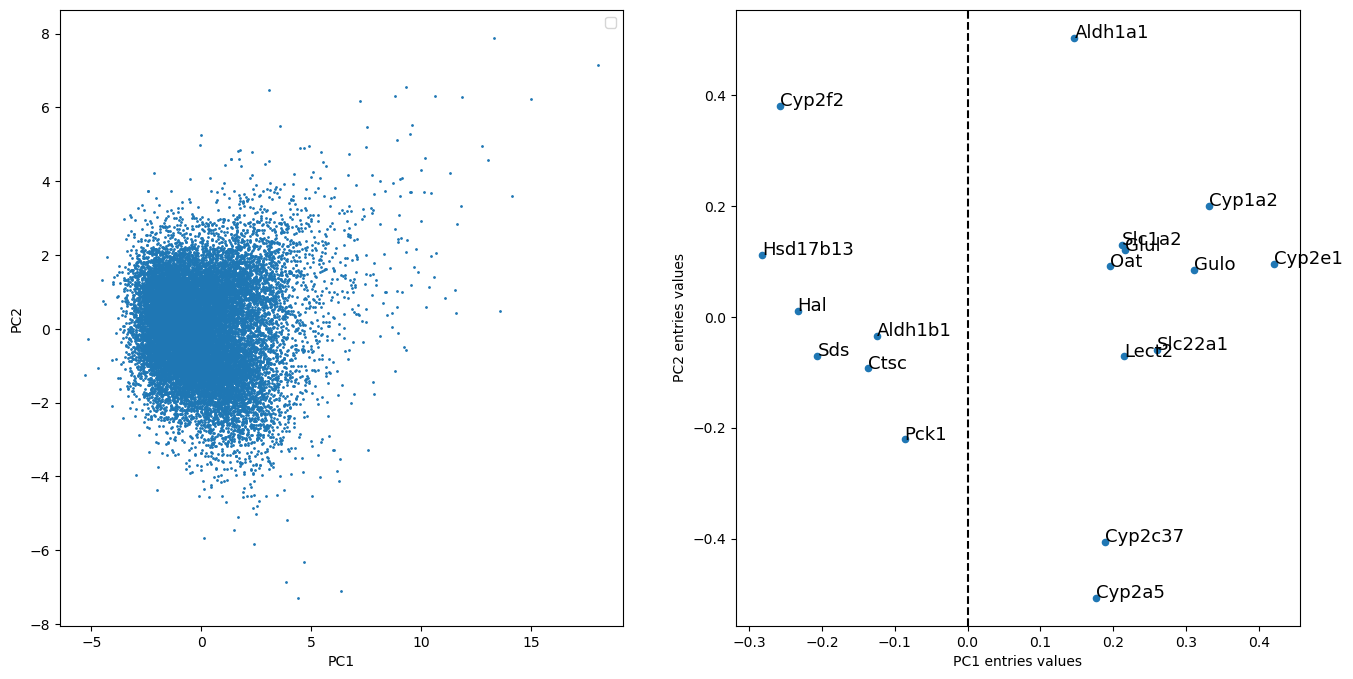

In [5]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.scatter(PC[:, 0], PC[:, 1],  s=1)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.scatter(PC[:,0], PC[:,1], s=1,  c=mask_f, cmap='plasma')
# first two eigenvectors
x = pca.components_[0, :]
y = pca.components_[1, :]

plt.subplot(122)
plt.scatter(x, y, 20)
ix = np.abs(x) > np.percentile(np.abs(x), 0)
iy = np.abs(y) > np.percentile(np.abs(y), 0)
ii = np.logical_or(ix, iy)
# print(np.sum(ii))
for i, txt in enumerate(data.var.index[ii]):
    plt.annotate(txt, (x[ii][i], y[ii][i]), fontsize=13)

#plot a vertical line for x = 0
plt.axvline(x=0, color='k', linestyle='--')

plt.xlabel("PC1 entries values")
plt.ylabel("PC2 entries values")


We can observe that PC1 perfectly separates protal to central genes, we therefore leverage the projection of data on such first principal component to initialize the bayesian model latent variables

In [6]:
# component that captures zonation, it needs to be checked
pc = 0
x_unif = PC[:, pc]
x_unif = x_unif - x_unif.mean()
x_unif = x_unif / np.sqrt(x_unif.var())

Here we also fit the the gene coefficients $a_g$ and $b_g$ with a Generalized Linear Model with Negative Bionomial noise: 
$$\forall c \forall g \\
\mu_{c,g} = exp(a_g * x_c + b_g)
$$
where $\mu_{c,g}$ is the mean of the negative binomial distrbution that generates the data entry $E_{c,g}$  
In this step the positions are kept fixed and the coefficients $a$ and $b$ are found for every gene

In [7]:
coef_pau = fit_coeff(data, x_unif, cfg.genes)

## Model's raining with gradient descent

Here we start the training:

In [8]:
help(training)

Help on function training in module utils:

training(data, x_unif, coef_pau, n_c, dm, clamp, n_iter, batch_size, dev)
    This function is used to train the model on the data.
    It's the only function where pytorch is used.



This cell is the traiing one, so it will take a while to execute

In [9]:
# the index of the gene to clamp
clamp = gene_index(data, cfg.clamp_gene)

x_, a0_, a1_, disp, losses = training(
    data.layers["n_cg"],
    x_unif,
    coef_pau,
    n_c,
    dm,
    clamp,
    cfg.n_iter,
    cfg.batch_size,
    cfg.dev,
)

This is the final output of the code, it's the x positios that are used in the GLMM

In [10]:
x_shifted, a0_shifted, a1_shifted, xs = shift_samples_per_mouse(
    x_, a0_, a1_, sample_id, cfg.central, data
)